In [2]:
import os
import logging

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import dill

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoDelta
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition


from cities.utils.data_grabber import (DataGrabber, list_available_features, list_tensed_features, list_interventions, list_outcomes)
from cities.utils.cleaning_utils import check_if_tensed, find_repo_root
from cities.modeling.model_interactions import cities_model_interactions as model
from cities.modeling.model_interactions import InteractionsModel
from cities.modeling.modeling_utils import (prep_data_for_interaction_inference,  train_interactions_model)
from cities.utils.cleaning_utils import find_repo_root

In [8]:
forward_shift = 2
outcome_dataset='unemployment_rate'
intervention_dataset='spending_commerce'

dg = DataGrabber()
dg.get_features_std_long([intervention_dataset, outcome_dataset])

root = find_repo_root()
log_dir = os.path.join(root, "data", "model_outputs/general_insights")
log_file_path = os.path.join(log_dir, ".general_insights.log")
os.makedirs(log_dir, exist_ok=True)

logging.basicConfig(filename=log_file_path, filemode="w", 
                format="%(asctime)s → %(name)s → %(levelname)s: %(message)s",
                datefmt="%Y-%m-%d %H:%M:%S", level=logging.INFO)

intervention_variable = dg.std_long[intervention_dataset].columns[-1]

loaded_data =  prep_data_for_interaction_inference(
        outcome_dataset=outcome_dataset,
intervention_dataset=intervention_dataset,
intervention_variable=intervention_variable,
forward_shift=forward_shift, 
    )


model_args = (
        loaded_data['N_t'],
        loaded_data['N_cov'],
        loaded_data['N_s'],
        loaded_data['N_u'],
        loaded_data['N_obs'],
        loaded_data['state_index_sparse'],
        loaded_data['state_index'],
        loaded_data['time_index'],
        loaded_data['unit_index'],
    )

Y_bias torch.Size([])
T_bias torch.Size([])
weight_TY torch.Size([])
sigma_T torch.Size([])
sigma_Y torch.Size([])
X_bias torch.Size([30, 1, 1, 1])
sigma_X torch.Size([30, 1, 1, 1])
weight_XT torch.Size([30, 1, 1, 1])
weight_XY torch.Size([30, 1, 1, 1])
weight_UsT torch.Size([51, 1, 1])
weight_UsY torch.Size([51, 1, 1])
weight_UsX torch.Size([30, 51, 1, 1])
weight_UtT torch.Size([11, 1, 1, 1, 1])
weight_UtY torch.Size([11, 1, 1, 1, 1])
X torch.Size([2998, 30])
T torch.Size([9124])
Y torch.Size([9124])


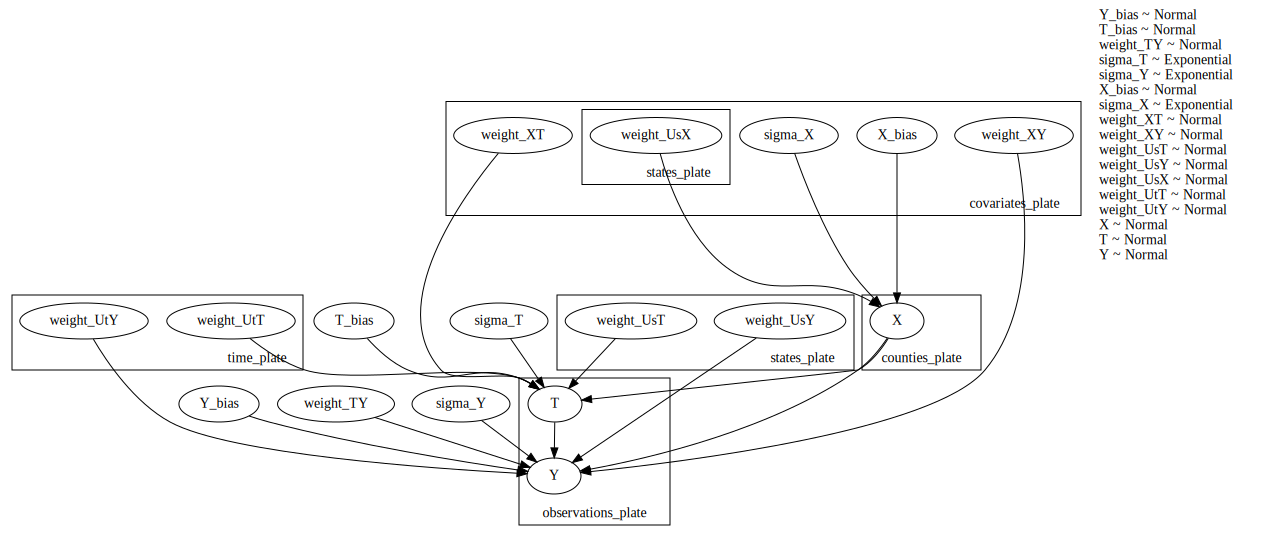

In [11]:

def cities_model_interactions(
    N_t,
    N_cov,
    N_s,
    N_u,
    N_obs,
    state_index_sparse,
    state_index,
    time_index,
    unit_index,
    leeway=0.2,
):
    Y_bias = pyro.sample("Y_bias", dist.Normal(0, leeway))
    T_bias = pyro.sample("T_bias", dist.Normal(0, leeway))

    weight_TY = pyro.sample("weight_TY", dist.Normal(0, leeway))

    sigma_T = pyro.sample("sigma_T", dist.Exponential(1))
    sigma_Y = pyro.sample("sigma_Y", dist.Exponential(1))

    observations_plate = pyro.plate("observations_plate", N_obs, dim=-1)

    counties_plate = pyro.plate("counties_plate", N_u, dim=-2)
    states_plate = pyro.plate("states_plate", N_s, dim=-3)
    covariates_plate = pyro.plate("covariates_plate", N_cov, dim=-4)
    time_plate = pyro.plate("time_plate", N_t, dim=-5)

    with covariates_plate:
        X_bias = pyro.sample("X_bias", dist.Normal(0, leeway)).squeeze()
        sigma_X = pyro.sample("sigma_X", dist.Exponential(1)).squeeze()
        weight_XT = pyro.sample("weight_XT", dist.Normal(0, leeway)).squeeze()
        weight_XY = pyro.sample("weight_XY", dist.Normal(0, leeway)).squeeze()

    with states_plate:
        weight_UsT = pyro.sample("weight_UsT", dist.Normal(0, leeway)).squeeze()
        weight_UsY = pyro.sample("weight_UsY", dist.Normal(0, leeway)).squeeze()

        with covariates_plate:
            weight_UsX = pyro.sample("weight_UsX", dist.Normal(0, leeway)).squeeze()

    with time_plate:
        weight_UtT = pyro.sample("weight_UtT", dist.Normal(0, leeway)).squeeze()
        weight_UtY = pyro.sample("weight_UtY", dist.Normal(0, leeway)).squeeze()

    with counties_plate:
        UsX_weight_selected = weight_UsX.squeeze().T.squeeze()[state_index_sparse]
        X_means = torch.einsum("c,uc->uc", X_bias, UsX_weight_selected)
        X = pyro.sample("X", dist.Normal(X_means, sigma_X)).squeeze()

    XT_weighted = torch.einsum("uc, c -> u", X, weight_XT)
    XY_weighted = torch.einsum("uc, c -> u", X, weight_XY)

    with observations_plate:
        T_mean = (
            T_bias
            + weight_UtT[time_index]
            + weight_UsT[state_index]
            + XT_weighted[unit_index]
        )

        T = pyro.sample("T", dist.Normal(T_mean, sigma_T))

        Y_mean = (
            Y_bias
            + weight_UtY[time_index]
            + weight_UsY[state_index]
            + weight_TY * T
            + XY_weighted[unit_index]
        )

        Y = pyro.sample("Y", dist.Normal(Y_mean, sigma_Y))

    return Y


with pyro.poutine.trace() as tr:
    cities_model_interactions(*model_args)
  
for key in tr.trace.nodes.keys():
    if not key.endswith("plate"):
        print(key, tr.trace.nodes[key]["value"].shape)


pyro.render_model( 
            cities_model_interactions, model_args=model_args, render_distributions=True
        )

In [13]:
model_conditioned =  pyro.condition(
            cities_model_interactions,
            data={"T": loaded_data['intervention'], "Y": loaded_data['y'], 
                  "X": loaded_data['covariates_sparse']},
        )

[iteration 0001] loss: 106779.9904


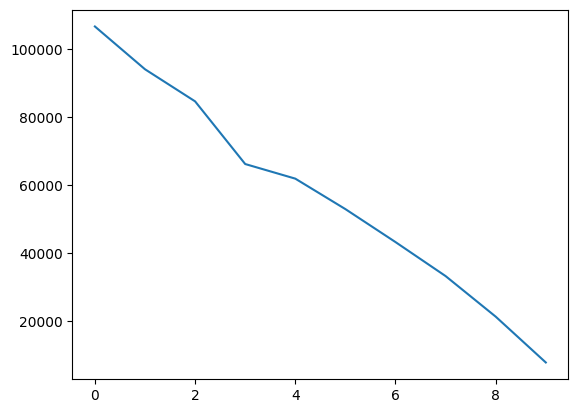

In [14]:
guide = train_interactions_model(model_conditioned, num_iterations=10, model_args=model_args , lr=0.1, plot_loss=True)


In [15]:
predictive = Predictive(model=cities_model_interactions, guide=guide, num_samples=1000, parallel=False)
samples = predictive(*model_args)

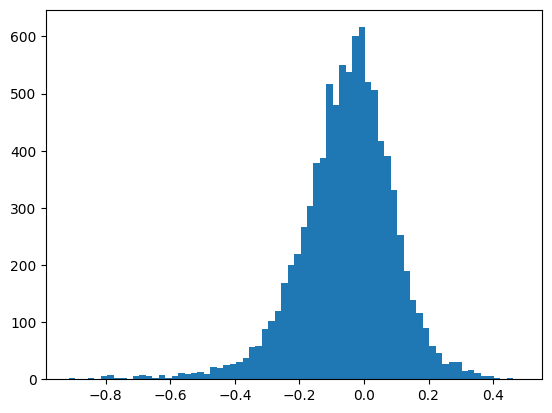

In [16]:
# plot residuals
y = loaded_data['y']
predictions = samples['Y'].squeeze().T
mean_predictions = torch.mean(predictions, dim = 1)

plt.hist(mean_predictions -y, bins=70)
plt.show()

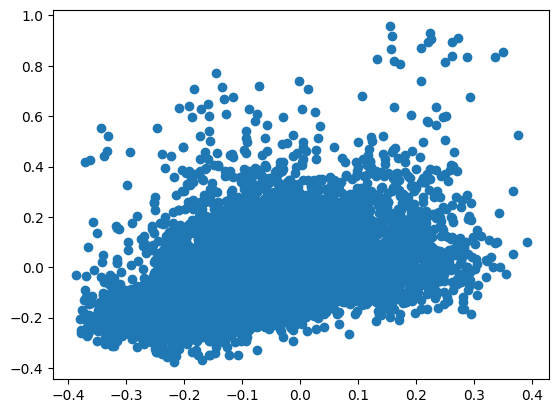

In [18]:
# predictive check
plt.scatter(mean_predictions, y)

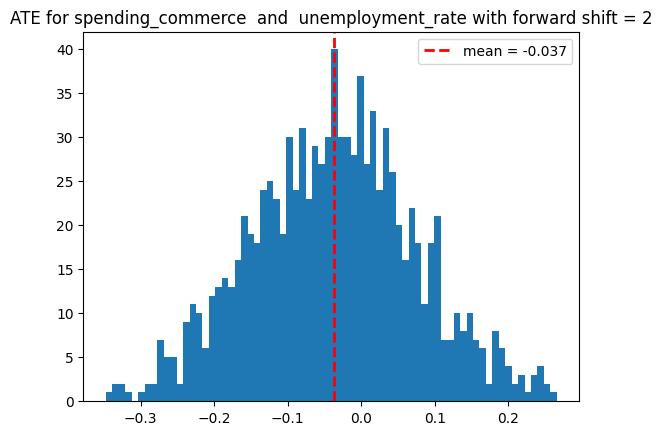

In [17]:
tau_samples = samples['weight_TY'].squeeze().detach().numpy()

plt.hist(tau_samples,bins = 70)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.title(f"ATE for {intervention_dataset}  and  {outcome_dataset} with forward shift = {forward_shift}")
plt.legend()
plt.show()